In [1]:
print("hiu")

hiu


In [2]:
!git clone https://github.com/facebookresearch/segment-anything-2.git


Cloning into 'segment-anything-2'...


In [6]:
%pip install hydra-core omegaconf einops opencv-python matplotlib tqdm


  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached einops-0.8.1-py3-none-any.whl.metadata (13 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
Using cached hydra_core-1.3.2-py3-none-any.whl (154 kB)
Using cached omegaconf-2.3.0-py3-none-any.whl (79 kB)
Using cached einops-0.8.1-py3-none-any.whl (64 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


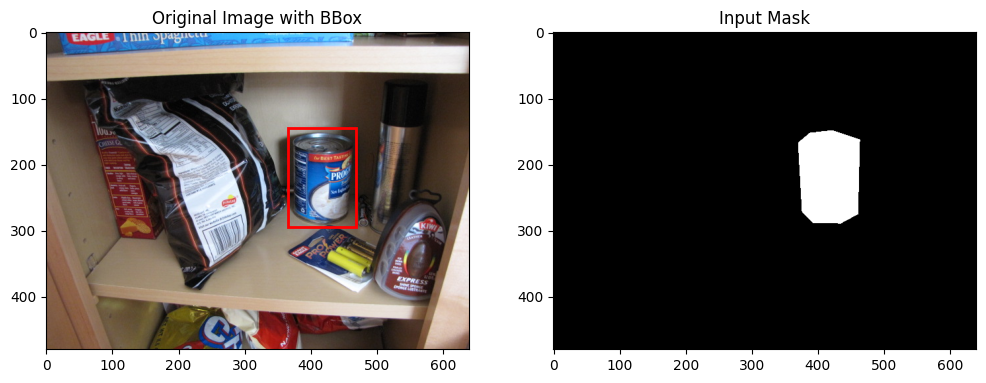

📦 Tracking with bbox: [366, 469, 145, 295]


propagate in video: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]


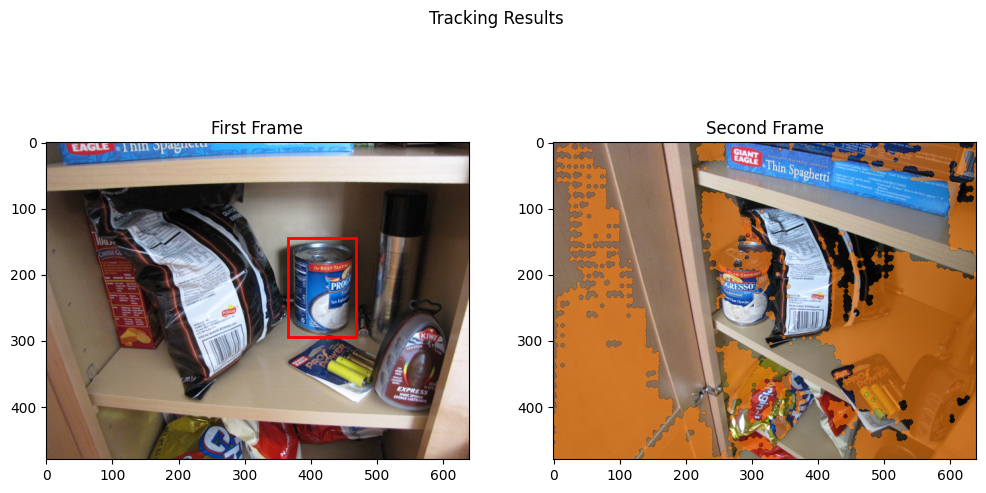

✅ Overlay saved to: tracked_overlay_obj1.png


In [70]:
import os
import sys
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import matplotlib.patches as patches
from skimage.morphology import binary_closing, binary_opening, disk

class SAM2ObjectTracker:
    def __init__(self, config_path=None, checkpoint_path=None):
        # Add SAM2 repo to path
        self.project_path = os.path.abspath(r"E:/project/segment_anything")
        if self.project_path not in sys.path:
            sys.path.insert(0, self.project_path)

        from sam2.sam2_image_predictor import SAM2ImagePredictor
        from sam2.sam2_video_predictor import SAM2VideoPredictor
        from sam2.build_sam import build_sam2_video_predictor
        from hydra import initialize_config_dir
        from hydra.core.global_hydra import GlobalHydra

        self.SAM2VideoPredictor = SAM2VideoPredictor
        self.build_sam2_video_predictor = build_sam2_video_predictor
        self.initialize_config_dir = initialize_config_dir
        self.GlobalHydra = GlobalHydra

        self.checkpoint = checkpoint_path if checkpoint_path else "sam2_hiera_tiny.pt"
        self.model_cfg = config_path if config_path else "sam2_hiera_t.yaml"
        self.tempfolder = "./tempdir"
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.create_if_not_exists(self.tempfolder)
        self.cleardir(self.tempfolder)

    def create_if_not_exists(self, dirname):
        os.makedirs(dirname, exist_ok=True)

    def cleardir(self, tempfolder):
        shutil.rmtree(tempfolder, ignore_errors=True)
        os.makedirs(tempfolder, exist_ok=True)

    def show_mask(self, mask, ax, obj_id=None, random_color=False):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            cmap = plt.get_cmap("tab10")
            cmap_idx = 0 if obj_id is None else obj_id
            color = np.array([*cmap(cmap_idx)[:3], 0.6])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def _postprocess_mask(self, mask):
        if mask.ndim > 2:
            mask = mask.squeeze()
        binary_mask = mask > 0.5
        if np.any(binary_mask):
            try:
                cleaned = binary_opening(binary_mask, footprint=disk(3))
                cleaned = binary_closing(cleaned, footprint=disk(3))
                return cleaned.astype(np.float32)
            except Exception as e:
                print(f"Warning: Morphological operations failed - {e}")
                return binary_mask.astype(np.float32)
        return binary_mask.astype(np.float32)

    def process_img_png_mask(self, img_path, mask_path, visualize=False, expand_bbox=5):
        mask = np.array(Image.open(mask_path))
        img = np.array(Image.open(img_path))
        if mask.shape[:2] != img.shape[:2]:
            raise ValueError("Mask and image dimensions don't match!")
        if mask.max() > 1:
            mask = (mask > 128).astype(np.uint8)
        nonzero = np.nonzero(mask)
        if len(nonzero[0]) == 0:
            raise ValueError("No object found in mask")
        ymin, ymax = np.min(nonzero[0]), np.max(nonzero[0])
        xmin, xmax = np.min(nonzero[1]), np.max(nonzero[1])
        ymin = max(0, ymin - expand_bbox)
        ymax = min(mask.shape[0], ymax + expand_bbox)
        xmin = max(0, xmin - expand_bbox)
        xmax = min(mask.shape[1], xmax + expand_bbox)
        if visualize:
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(img)
            ax[0].add_patch(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='r', facecolor='none'))
            ax[0].set_title("Original Image with BBox")
            ax[1].imshow(mask, cmap='gray')
            ax[1].set_title("Input Mask")
            plt.show()
        return [xmin, xmax, ymin, ymax]

    def build_predictor(self):
        config_abs = os.path.abspath(os.path.dirname(self.model_cfg))
        config_name = os.path.basename(self.model_cfg)
        if self.GlobalHydra.instance().is_initialized():
            self.GlobalHydra.instance().clear()
        with self.initialize_config_dir(config_dir=config_abs, version_base=None):
            return self.build_sam2_video_predictor(
                config_file=config_name,
                checkpoint=self.checkpoint,
                device=self.device
            )

    def save_overlayed_mask_image(self, img_path, mask, save_path, alpha=0.3):
        """Save image with mask overlay restricted to detected object region"""
        try:
            img = np.array(Image.open(img_path).convert('RGB'))
            # Post-process mask
            proc_mask = self._postprocess_mask(mask)
            # Compute bounding box of the mask
            coords = np.argwhere(proc_mask)
            if coords.size == 0:
                print("❌ Mask empty, skipping overlay.")
                return False
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0)
            # Crop mask to object region
            cropped_mask = np.zeros_like(proc_mask)
            cropped_mask[y0:y1+1, x0:x1+1] = proc_mask[y0:y1+1, x0:x1+1]
            # Create overlay only on cropped region
            overlay = np.zeros_like(img)
            # Expand dims if needed
            mask3 = np.expand_dims(cropped_mask, axis=-1)
            overlay = overlay * 0
            overlay[mask3.squeeze() > 0] = [255, 0, 0]
            # Blend
            blended = (img * (1 - alpha) + overlay * alpha).astype(np.uint8)
            Image.fromarray(blended).save(save_path)
            print(f"✅ Overlay saved to: {save_path}")
            return True
        except Exception as e:
            print(f"Error saving overlay: {e}")
            return False
        overlay = np.zeros_like(img)
        overlay[mask>0] = [255,0,0]
        blended = (img*(1-alpha)+overlay*alpha).astype(np.uint8)
        Image.fromarray(blended).save(save_path)
        print(f"✅ Overlay saved to: {save_path}")
        return True

    def track_item_boxes(self, img1, img2, boxes, visualize=True):
        predictor = self.build_predictor()
        if predictor is None:
            raise RuntimeError("Failed to init predictor")
        self.cleardir(self.tempfolder)
        shutil.copy(img1, os.path.join(self.tempfolder,'00000.jpg'))
        shutil.copy(img2, os.path.join(self.tempfolder,'00001.jpg'))
        state = predictor.init_state(video_path=self.tempfolder)
        predictor.reset_state(state)
        _, obj_ids, logits = predictor.add_new_points_or_box(
            inference_state=state, frame_idx=0, obj_id=1, box=np.array(boxes[0][0],dtype=np.float32)
        )
        segs={}
        for f, ids, lg in predictor.propagate_in_video(state):
            for i, oid in enumerate(ids):
                m=(lg[i]>0).cpu().numpy().squeeze()
                segs.setdefault(f,{})[oid]=m
        if visualize:
            fig,ax=plt.subplots(1,2,figsize=(12,6))
            fig.suptitle('Tracking Results')
            ax[0].imshow(Image.open(img1)); ax[0].add_patch(patches.Rectangle((boxes[0][0][0],boxes[0][0][2]),boxes[0][0][1]-boxes[0][0][0],boxes[0][0][3]-boxes[0][0][2],edgecolor='r',linewidth=2,fill=False))
            ax[0].set_title('First Frame')
            ax[1].imshow(Image.open(img2))
            for oid,mask in segs.get(1,{}).items(): self.show_mask(self._postprocess_mask(mask),ax[1],obj_id=oid)
            ax[1].set_title('Second Frame')
            plt.show()
        return segs

if __name__=="__main__":
    f1=r"E:/project/CMU10_3D/CMU10_3D/data_2D/can_chowder_000001.jpg"
    m1=r"E:/project/CMU10_3D/CMU10_3D/data_2D/can_chowder_000001_1_gt.png"
    f2=r"E:/project/CMU10_3D/CMU10_3D/data_2D/can_chowder_000002.jpg"
    tracker=SAM2ObjectTracker()
    bbox=tracker.process_img_png_mask(f1,m1,visualize=True)
    if bbox:
        print(f"📦 Tracking with bbox: {bbox}")
        segs=tracker.track_item_boxes(f1,f2,[(bbox,1)],visualize=True)
        tracker.save_overlayed_mask_image(f2,segs[1][1],'tracked_overlay_obj1.png')
    else:
        print("❌ Failed to get bbox.")
